# L-RVGA comparisson

In this notebook, we make use of the [XP_LRVGA_LinearRegression.py](https://github.com/marc-h-lambert/L-RVGA/blob/main/XP_LRVGA_LinearRegression.py) script to benchmark L-RVGA and LoFi.

In [1]:
import jax
import pickle
import jax.numpy as jnp
import matplotlib.pyplot as plt
from rebayes.base import RebayesParams
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi

In [2]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [3]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

## Load data

In [4]:
file = "./LRVGA_data.pkl"
with open(file, "rb") as f:
    data = pickle.load(f)

# To TPU
data = jax.tree_map(jnp.array, data)
jax.tree_map(jnp.shape, data)

{'X': (10000, 100),
 'cov_inputs': (100, 100),
 'ekf-divergence': {'full-kf': (9999, 1),
  'p-1': (9999, 1),
  'p-10': (9999, 1),
  'p-20': (9999, 1),
  'p-50': (9999, 1)},
 'kf-posterior-cov': (100, 100),
 'kf-posterior-mean': (100, 1),
 'params_true': (100,),
 'y': (10000,)}

### Compute posterior parameters

In [26]:
# Explicit solution
pcov = jnp.linalg.inv(data["X"].T @ data["X"] + jnp.eye(num_features))
pmean = pcov @ data["X"].T @ data["y"]

In [6]:
# From KF result
pcov = data["kf-posterior-cov"]
pmean = data["kf-posterior-mean"].ravel()

## Initialise Rebayes

In [27]:
def callback(bel, pred_obs, *args, **kwargs):
    dist_true = tfd.MultivariateNormalFullCovariance(pmean, pcov)
    dist_ekf = tfd.MultivariateNormalFullCovariance(bel.mean, bel.cov)
    
    kld = tfd.kl_divergence(dist_ekf, dist_true)
    return {
        "kl": kld
    }

In [28]:
num_samples, num_features = data["X"].shape

In [59]:
initial_mean = jnp.zeros(num_features)
dynamics_covariance = 1.0
initial_covariance = 0.1 
dynamics_weights = 1.0

def emission_cov_fn(w, x): return 1.0
def emission_mean_fn(w, x): return jnp.einsum("m,...m->", w, x)

In [126]:
params = RebayesParams(
    initial_mean,
    initial_covariance,
    dynamics_weights,
    dynamics_covariance,
    emission_mean_fn,
    emission_cov_fn
)


# Try 50, 99, and 100. See differences
params_lofi50 = lofi.LoFiParams(memory_size=50, adaptive_variance=False)
params_lofi99 = lofi.LoFiParams(memory_size=99, adaptive_variance=False)
params_lofi100 = lofi.LoFiParams(memory_size=100, adaptive_variance=False)

In [127]:
estimator_kf = ekf.RebayesEKF(params, method="fcekf", adaptive_variance=False)
estimator_lofi50 = lofi.RebayesLoFi(params, params_lofi50, "full_svd_lofi")
estimator_lofi99 = lofi.RebayesLoFi(params, params_lofi99, "full_svd_lofi")
estimator_lofi100 = lofi.RebayesLoFi(params, params_lofi100, "full_svd_lofi")

In [128]:
output_lofi50, hist_lofi50 = estimator_lofi50.scan(data["X"], data["y"], callback=callback)
output_lofi99, hist_lofi99 = estimator_lofi99.scan(data["X"], data["y"], callback=callback)
output_lofi100, hist_lofi100 = estimator_lofi100.scan(data["X"], data["y"], callback=callback)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [129]:
output_kf, hist_kf = estimator_kf.scan(data["X"], data["y"], callback=callback)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0, 0.5, 'Number observations')

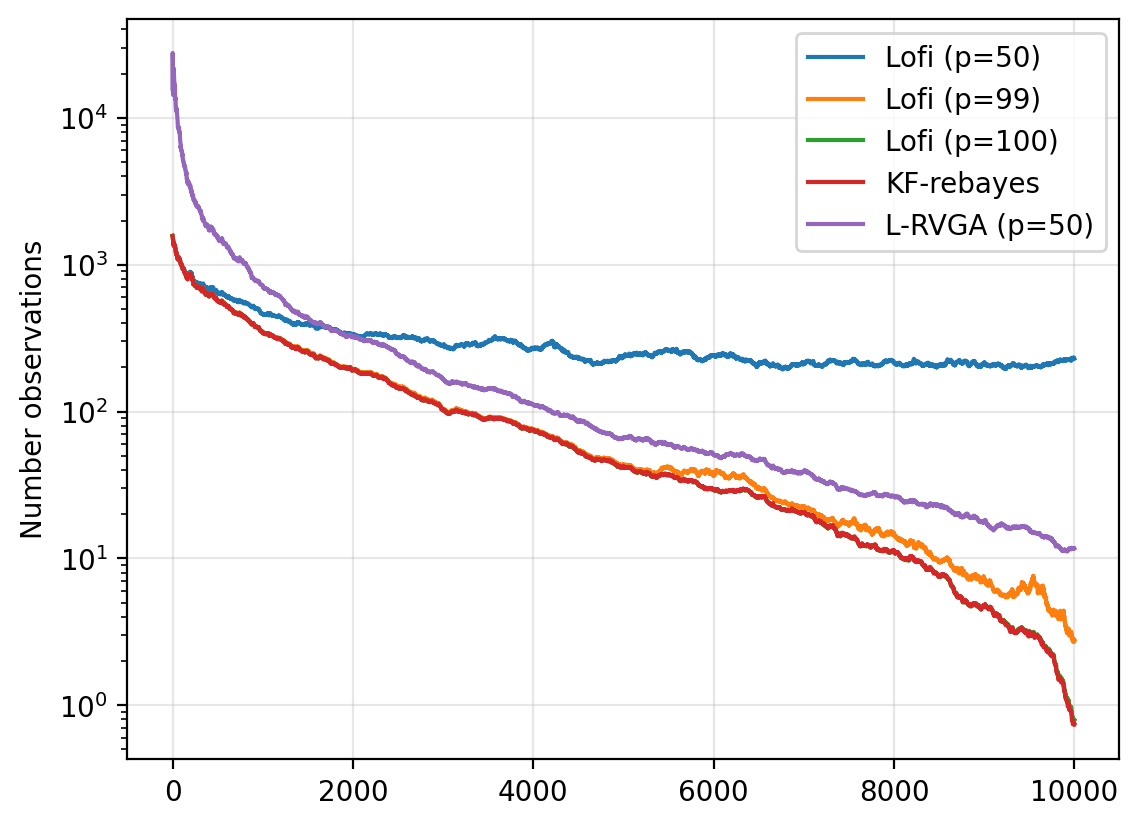

In [130]:
plt.plot(hist_lofi50["kl"], label="Lofi (p=50)")
plt.plot(hist_lofi99["kl"], label="Lofi (p=99)")
plt.plot(hist_lofi100["kl"], label="Lofi (p=100)")
plt.plot(hist_kf["kl"], label="KF-rebayes")
# plt.plot(data["ekf-divergence"]["full-kf"].ravel(), label="kf-lambert+")
plt.plot(data["ekf-divergence"]["p-50"].ravel(), label="L-RVGA (p=50)")
plt.legend()
plt.yscale("log")
plt.ylabel("KL(q||p)")
plt.grid(alpha=0.3)
plt.ylabel("Number observations")

In [116]:
dist_true = tfd.MultivariateNormalFullCovariance(pmean, pcov)
dist_ekf = tfd.MultivariateNormalFullCovariance(output_kf.mean, output_kf.cov)

tfd.kl_divergence(dist_ekf, dist_true)

Array(0.73898363, dtype=float32)

In [102]:
dist_lofi = tfd.MultivariateNormalFullCovariance(output_lofi.mean, output_lofi.cov)
tfd.kl_divergence(dist_lofi, dist_true)

Array(0.78823495, dtype=float32)

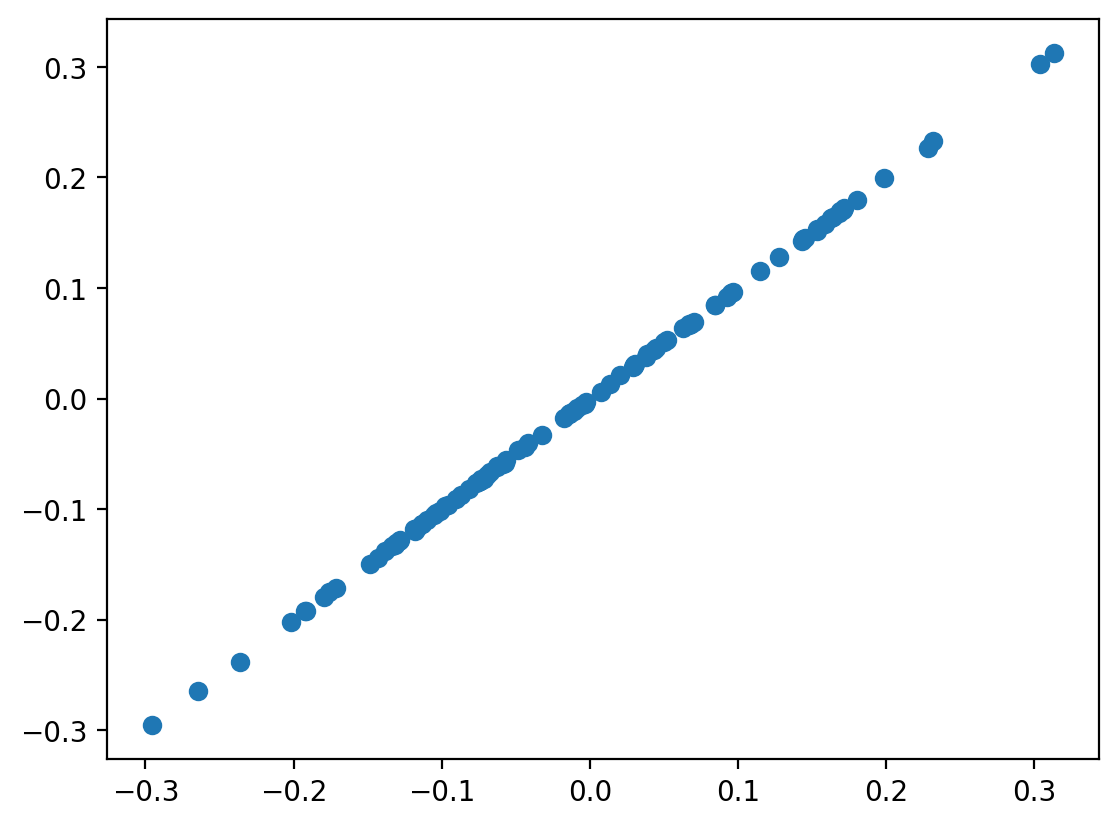

In [103]:
plt.scatter(output_kf.mean, output_lofi.mean)